The following notebook gives a simple and intuitive method for analysing and predicting stock price changes using gated recurrent neural netoworks. The method is neither precise nor optimal in any way, but stands as an intuitive base for future development of stock market analysis using GRUs (or LSTMs). Moreover, the notebook is primarily used by the author to learn and improve his own skills when it comes to analysis of complex systems (like the stock market). Some of these ideas are directly inspired by this really interesting article: https://towardsdatascience.com/aifortrading-2edd6fac689d#f8df... others are my own. 


First we import all the relevant packages needed to do this..

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import datetime
import torch
import torch.nn as nn
from torch.nn import functional
import time
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

We want to use the computer's graphic card (if it has one). 

In [2]:
with torch.cuda.device('cuda:0'):
    torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.FloatTensor')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
def create_matrix(df, stocknames=list, p_type='Close'):
    """
    Returns a dataframe with only one defined feature of the stock (p_type) 
    default is p_type='Close' for the closing price of the stock
    """
    df2 = pd.DataFrame(index = df.index)
    
    for stock in stocknames:
        df2[stock] = df[stock, p_type]
    
    return df2

def split_data_df(stockx, stocky, lookback=21, future=1, ratio=.2):
    """
    Function returns list of both training and testing data with the form
    [train_input, train_output. test_input, test_output]. 
    
    arguments:
    stockx: the input data (pandas dataframe) with dimensions [time, feature1, feature2, feature3..., featureN]
    stocky: ground truth output data with dimensions [time, value]
    """
    datax = []
    datay = []
    
    # create all possible sequences of length seq_len
    for index in range(len(stockx) - (lookback - 1 + future)): 
        datax.append(stockx.iloc[index: index + lookback].values)
        datay.append(stocky.iloc[index + lookback - 1 + future].values)
    
    datax = np.array(datax)
    datay = np.array(datay)
    test_set_size = int(np.round(ratio*len(stockx)));
    train_set_size = len(stockx) - (test_set_size);
    
    x_train = datax[:train_set_size,:-1,:]
    y_train = datay[:train_set_size,-1]
    
    x_test = datax[train_set_size:,:-1, :]
    y_test = datay[train_set_size:,-1]
    
    return [x_train, y_train, x_test, y_test]

def get_correlation_img(corr_df, headline, tx=True):
    
    """
    Method thar returns heat-map of correlation coefficients of dataframe columns. headline is optional, tx controls if each 
    square should include the coefficient value. 
    """
    stocks = corr_df.columns
    index = corr_df.index
    fig, ax = plt.subplots()
    im = ax.imshow(corr_df, cmap='RdBu', vmin=-1, vmax=1)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(stocks)))
    ax.set_yticks(np.arange(len(index)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(stocks)
    ax.set_yticklabels(index)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    c_val = corr_df.values
    
    # Loop over data dimensions and create text annotations.
    if tx:
        for i in range(len(stocks)):
            for j in range(len(index)):
                val=round(c_val[i, j], 3)
                text = ax.text(j, i, round(c_val[i, j], 3),
                           ha="center", va="center", color="black")


    ax.set_title(headline)
    fig.tight_layout()
    plt.grid(None)
    plt.show()
    
def get_scaled_dataframe(df, frange=(-1, 1)):
    """
    Method returns scaled dataframe with specified range by frange.
    """
    scaler = MinMaxScaler(feature_range=frange)
    x = df.values
    x_scaled = scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, columns=df.columns, index=df.index)

def scale_column(df, colname=str, frange=(0, 1)):
    
    """
    Method returns the same dataframe but with a scaled column specified by colname
    """
    scaler = MinMaxScaler(feature_range=frange)
    x = df[[colname]].values
    x_scaled = scaler.fit_transform(x)
    df[colname] = x_scaled
    return df

def get_technical_indicators(stock):
    
    """
    Method returns dataframe with added technical indicators (features often used in stock market analysis)
    """
    stock['Change'] = stock.High - stock.Low

    stock['ma7'] = stock['Close'].rolling(window=7).mean()
    stock['ma21'] = stock['Close'].rolling(window=21).mean()

    # Create MACD
    stock['26ema'] = stock['Close'].ewm(span=26).mean()
    stock['12ema'] = stock['Close'].ewm(span=12).mean()
    stock['MACD'] = (stock['12ema']-stock['26ema'])

    stock['mm7'] = stock['Adj Close'].rolling(7).median()
    stock['mm21'] = stock['Close'].rolling(21).median()
    stock['std7'] = stock['Adj Close'].rolling(7).std()
    stock['std21'] = stock['Close'].rolling(21).std()

    stock['upper_band'] = stock['ma21'] + (stock['std21']*2)
    stock['lower_band'] = stock['ma21'] - (stock['std21']*2)

    stock['ema'] = stock['Close'].ewm(com=0.5).mean()
    stock['momentum'] = stock['Close']-1

    stock['diff'] = stock['Close'].diff(1)
    #stock['vol_diff'] = stock.Volume.diff()
    #stock['mov_vol_mean'] = stock.Volume.rolling(7).mean()
    #stock['mov_vol_std'] = stock.Volume.rolling(7).std()
    stock = stock.fillna(value=0)
    stock = stock.iloc[7+21:]
    
    return stock

Let's look at the correlation between some stocks in the tech industry... in this notebook we use yahoos API

[*********************100%***********************]  9 of 9 completed


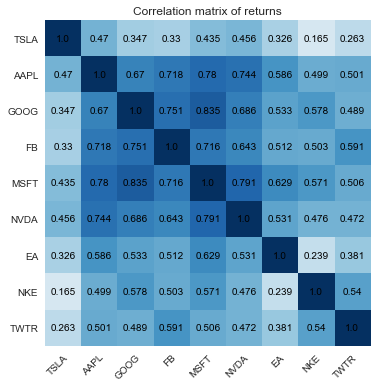

In [4]:
#Setting the end date to today
end = datetime.datetime.today()
end = datetime.datetime(end.year,end.month,end.day)
#Start date 
start = datetime.datetime(end.year-1,end.month,end.day)

idx = pd.date_range(start, end)

# A list of stock tickers!
stocks = ['TSLA', 'AAPL', 'GOOG', 'FB', 'MSFT', 'NVDA', 'EA', 'NKE', 'TWTR']
#stocks = ['BTC-USD', 'ETH-USD', 'LTC-USD']


#Download dataframe of all stocks, with columns: Open High Low Close Adj_Close Volume

S = yf.download(stocks, start=start, end=end, interval='1d', group_by='ticker')

SC = create_matrix(S, stocknames=stocks, p_type = 'Adj Close')
R = SC.diff(1)
# Let's see which ones of the stocks' returns correlate!
get_correlation_img(R.corr(method='pearson'), headline='Correlation matrix of returns')

Now we see some really evident correlations (which means they can be used as features in the input data). Let's put that aside for now and focus on one stock in particular.

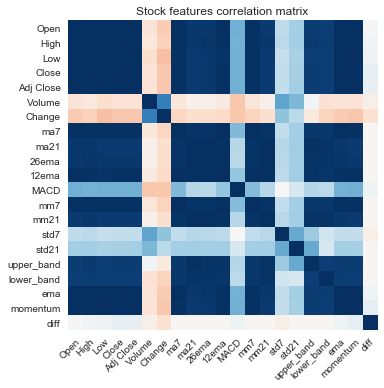

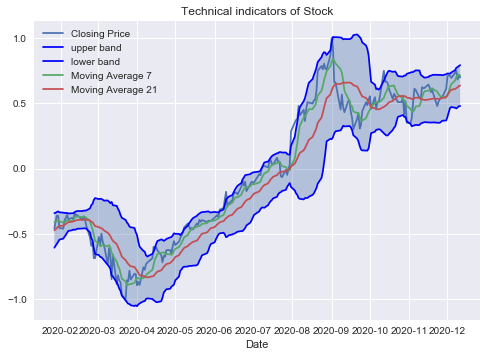

In [6]:
# Ok, we will take a look at Apple
stock = S['AAPL']
stock = get_scaled_dataframe(stock, frange=(-1, 1))
stock = scale_column(stock, 'Volume', frange=(0, 1))
stock = get_technical_indicators(stock)
x_ =list(stock.index)
get_correlation_img(stock.corr(method='pearson'), headline='Stock features correlation matrix', tx=False)
plt.plot(stock['Close'], label='Closing Price')
plt.plot(stock['upper_band'], label='upper band', color='b')
plt.plot(stock['lower_band'], label='lower band', color='b')
plt.plot(stock['ma7'], label='Moving Average 7')
plt.plot(stock['ma21'], label='Moving Average 21')
plt.fill_between(x_, stock['lower_band'], stock['upper_band'], alpha=0.35)
plt.title('Technical indicators of Stock')

plt.xlabel('Date')
plt.legend()
plt.show()

Perhaps the fourier transforms hold some information that can be grasped by our network?

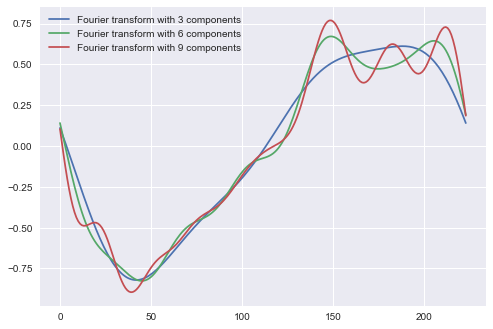

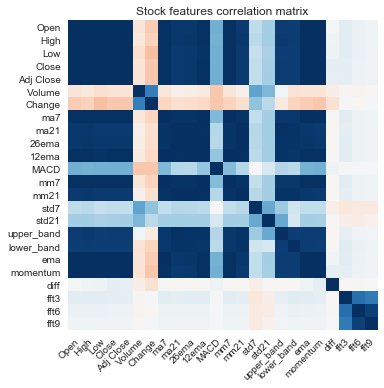

In [8]:
data_FT = stock[['Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    stock['fft{}'.format(num_)] = fft_list_m10
plt.legend()
get_correlation_img(stock.corr(method='pearson'), headline='Stock features correlation matrix', tx=False)

In [9]:
# Now separate the features columns from the label (the closing price next day)
# we scan a window of 20 days to predict the price change of the next day. 
lookback = 20
future = 1

prediction='diff'

features = list(stock.drop([prediction], axis=1).columns)
label = [prediction]
obs = stock[label].values[lookback-1+future:]

# Create the dataset for training and testing
x_train, y_train, x_test, y_test = split_data_df(stock[features], stock[label], lookback=lookback, future=future)

# Pytorch wants its inputs to be torch tensors!
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [10]:
# Define the parameters for the input of the recurrent neural network
input_dim = x_train.shape[-1]
hidden_dim = 128
output_dim = 1
num_layers = 3
num_epochs=300

In [11]:
# Define the neural network!
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=.02)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.mean = 0
        self.std=.5
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = functional.sigmoid(out)
        out = self.fc(out[:, -1, :])
        out = torch.reshape(out, (len(out),)) # Needed because several features!
        out = functional.tanh(out)
        return out

We train our model

****************************************************************************************************
Epoch 0 ----- training error = 0.015234687365591526 ----- validation error = 0.012516584247350693
Epoch 50 ----- training error = 0.004644653759896755 ----- validation error = 0.00906072836369276
Epoch 100 ----- training error = 0.0037747484166175127 ----- validation error = 0.00829694326967001
Epoch 150 ----- training error = 0.0031510917469859123 ----- validation error = 0.0048000141978263855
Epoch 200 ----- training error = 0.0013201902620494366 ----- validation error = 0.0044666253961622715
Epoch 250 ----- training error = 0.0006237905472517014 ----- validation error = 0.003774529555812478
****************************************************************************************************
Training time: 8.08 s
****************************************************************************************************
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB
204
204


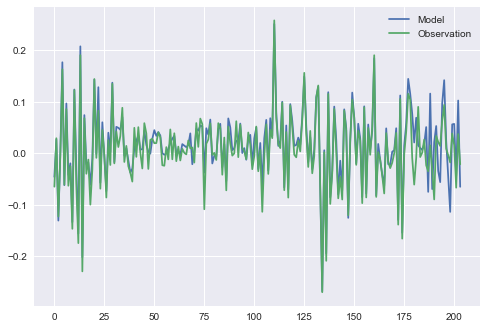

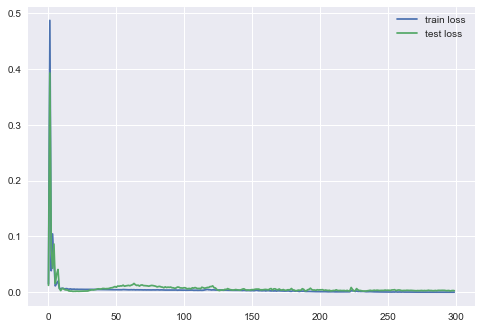

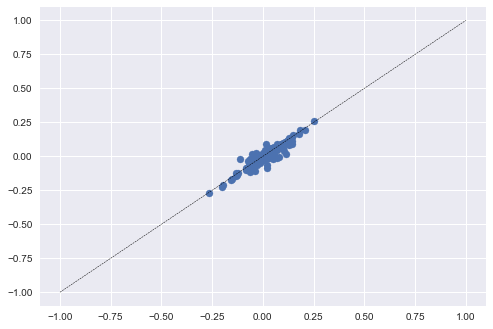

In [12]:
with torch.cuda.device('cuda:0'):
    torch.cuda.empty_cache()
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

error_train = np.zeros(num_epochs)
error_test = np.zeros(num_epochs)
start_time = time.time()
PATH = 'Models/model_history'

sd = model.state_dict()
print('*'*100)
for t in range(num_epochs):
    y_train_pred = model(x_train) 
    y_test_pred = model(x_test)
    loss = criterion(y_train_pred, y_train)
    loss_test = criterion(y_test_pred, y_test)
    error_train[t] = loss.item()    
    error_test[t] = loss_test.item()
    torch.save(model.state_dict(), PATH+'{}'.format(t))
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    if t%50 == 0:
        print("Epoch {} ----- training error = {} ----- validation error = {}".format(t, error_train[t], error_test[t]))
    
training_time = time.time()-start_time
print('*'*100)
print("Training time: {} s".format(round(training_time, 2)))
print('*'*100)
if device.type == 'cuda':
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

ar = model(x_train)
ar = ar.cpu().detach().numpy()
yy = model(x_test)
yy = yy.cpu().detach().numpy()
ar = np.concatenate((ar, yy))
print(len(ar))
print(len(obs))
plt.plot(ar[:], label='Model')
plt.plot(obs[:], label='Observation')
plt.legend()
plt.show()
plt.plot(error_train, label='train loss')
plt.plot(error_test, label='test loss')
plt.legend()
plt.show()
plt.scatter(ar, obs)
plt.plot(np.linspace(-1, 1, len(ar)), np.linspace(-1, 1, len(ar)), 'k--', linewidth=.5)
plt.show()
with torch.cuda.device('cuda:0'):
    torch.cuda.empty_cache()

At this stage our model is overtrained, but could this still be useful? We want the model to be sensitive to high frequencies. But let's also see how it performs in the epoch with the smalles test error.

ar len: 204
obs len: 204


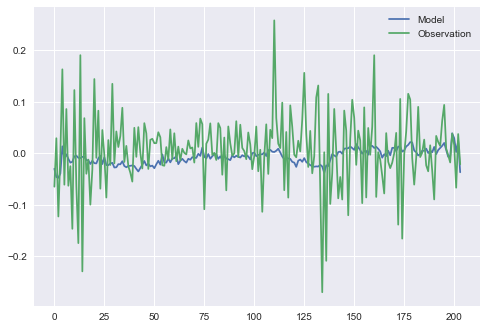

Training error at epoch 18:  0.00554864015430212
Test error at epoch 18:  0.0017448136350139976


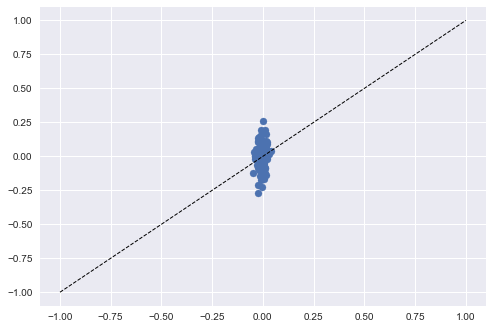

In [16]:
model3 = GRU(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)
indx = np.argmin(error_test)
state_dic = torch.load(PATH+'{}'.format(indx))
model3.load_state_dict(state_dic)

x_train, y_train, x_test, y_test = split_data_df(stock[features], 
                                                 stock[label], 
                                                 lookback=lookback, 
                                                 future=future, 
                                                 ratio=0)

x_train = torch.from_numpy(x_train).type(torch.Tensor)

ar = model3(x_train)
ar = ar.cpu().detach().numpy()

ara = ar[:]
obsa = obs[:]
print("ar len:", len(ar))
print("obs len:", len(obs))

plt.plot(ara, label='Model')
plt.plot(obsa[:], label='Observation')
plt.legend()
plt.show()
aapl = ar
print("Training error at epoch {}: ".format(indx), error_train[indx])
print("Test error at epoch {}: ".format(indx), error_test[indx])

plt.scatter(ara, obsa)
plt.plot(np.linspace(-1, 1, len(ar)), np.linspace(-1, 1, len(ar)), 'k--', linewidth=1)
plt.show()

This proved not to be so good in terms of accuracy... But remember our goal is not to predict the exact price change, but rather if the price will go up or down!

25


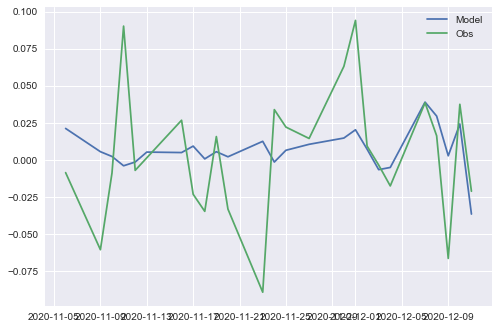

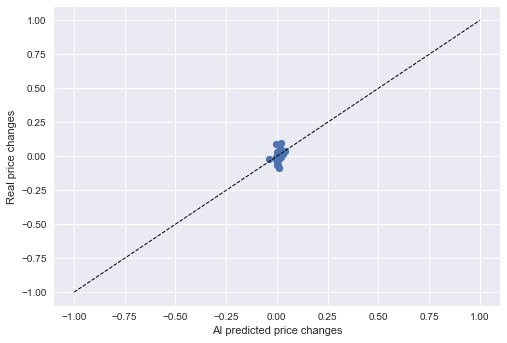

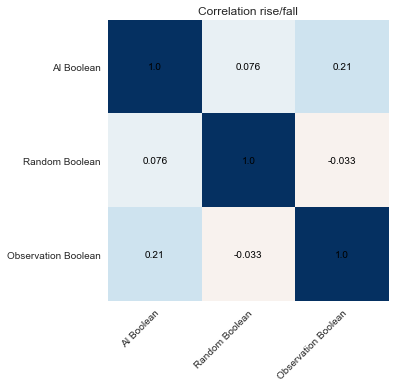

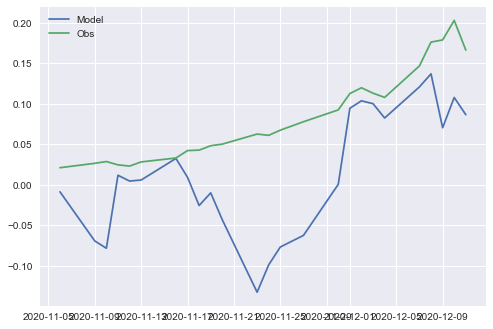

In [19]:
x_train, y_train, x_test, y_test = split_data_df(stock[features], 
                                                 stock[label], 
                                                 lookback=lookback, 
                                                 future=future, 
                                                 ratio=0.2)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_train = torch.from_numpy(x_test).type(torch.Tensor)
diffdays = 1
AI = pd.DataFrame(index = stock.index)
AI = AI.iloc[lookback - 1 + future:]
print(len(x_test))
AI['Model'] = ar
AI['Observation'] = obs
AI['AI Boolean'] = np.where(AI['Model'] > 0, 1, 0)
AI['Observation Boolean'] = np.where(AI['Observation'] > 0, 1, 0)
AI['Random Boolean'] = np.random.randint(2, size=len(AI))
AI = AI.iloc[-len(x_test):]
plt.plot(AI['Model'][-len(x_test):], label='Model')
plt.plot(AI['Observation'][-len(x_test):], label='Obs')
plt.legend()
plt.show()

plt.scatter(AI['Model'],AI['Observation'])
plt.xlabel('AI predicted price changes')
plt.ylabel('Real price changes')
plt.plot(np.linspace(-1, 1, len(ar)), np.linspace(-1, 1, len(ar)), 'k--', linewidth=1)
plt.show()


get_correlation_img(AI[['AI Boolean', 'Random Boolean', 'Observation Boolean']].corr(method='pearson'), headline='Correlation rise/fall')

plt.plot(AI['Observation'].cumsum(), label='Model')
plt.plot(AI['Model'].cumsum(), label='Obs')
plt.legend()
plt.show()

And we see that the model has rather good correlation with the actual path (a coefficient of .21). This result could be subject to several sources of error, but still a correlation of .21 is better than a random guess. 

In [36]:
torch.save(model,'Models/stockpredictionmodel')